# КЛАСТЕРИЗАЦИЯ НА ГРАФАХ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

In [2]:
# чтение данных

all_data = pd.read_csv('/mnt/data/all.csv')
all_data.columns = ['lot_id', 'creditor', 'sum', 'material', 'short_text', 'currency', 'scale', 'short_material_text', 'mat_class', 'name_text']

## Сбор данных для создания графа (линки, ноды)

In [3]:
materials_by_creditor = pd.DataFrame(all_data.groupby(['creditor'])['material'].apply(lambda x: x.unique())).reset_index()

In [4]:
tmp_materials = materials_by_creditor[:100]
all_materials_list = []

for materials_list in tmp_materials.material:
    all_materials_list.extend(materials_list)

all_materials_unique = np.unique(all_materials_list)

In [5]:
def create_links_from_cell(cell_list):
    edge_list = []

    for i in range(len(cell_list)):
        for j in range(i+1, len(cell_list)):
            edge_list.append((cell_list[i], cell_list[j], round(random.random(), 1)))

    return edge_list

In [6]:
node_creditor = {}
double_material = []

for creditor, materials in tmp_materials.values:
    for material in materials:
        if material in node_creditor:
            double_material.append(material)
        node_creditor.update({material:creditor})

deleted = 0

for material in double_material:
    deleted += int(node_creditor.pop(material, None) is not None)

## Создание графа

In [7]:
# сборка графа

G = nx.Graph()

nodes = all_materials_unique

edges_with_weights = []
for materials_list in tmp_materials.material.values:
    edges_with_weights.extend(create_links_from_cell(materials_list))

G.add_nodes_from(nodes)

for edge in edges_with_weights:
    G.add_edge(edge[0], edge[1], weight=edge[2])

## Кластеризация

In [8]:
# кластеризация (1 элемент = 1 кластер, внутри кластера (set) лежат материалы, принадлежащие кластеру)

communities = list(nx.algorithms.community.label_propagation_communities(G)) 

In [9]:
lens = [len(el) for el in communities] # размеры кластеров (кол-во материалов в каждом)
len(lens) # кол-во кластеров

69

In [10]:
colors = {k+1:"#"+"%06x" % random.randint(0, 0xFFFFFF) for k in range(len(communities))} # уникальный цвет для каждого кластера
len(colors)

69

In [11]:
node_cred = {} # к какому кластеру относится каждый материал ({материал: кластер})

for node in G:
    for i in range(len(communities)):
        if node in communities[i]:
            node_cred[node] = i+1

## Визуализация

KeyboardInterrupt: 

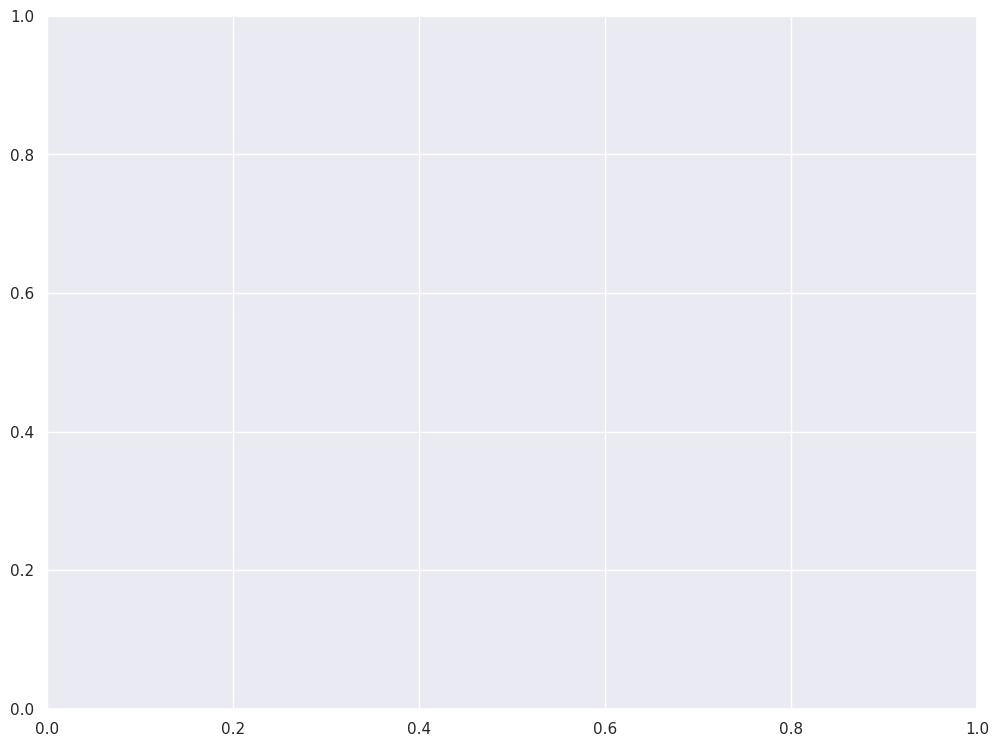

In [12]:
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(12, 9))

pos = nx.spring_layout(G)
color_map = [colors[node_cred[node]] for node in G] # цвет для каждой ноды (покластерно)
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=30,font_size=3, ax=ax, node_color=color_map)

plt.show()